In [9]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [10]:
mu = 1
sigma = 2.0
learning_rate = 1e-3
epsilon = 1.5
epochs = 3
test_size = 100

In [11]:
# define loss
def linear_loss(output, target):
#     print('output', output.size(), output)
#     print('target', target.size(), target)
    return output.t() @ target

# FGSM attack
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
#     print('fgsm X, delta, y, sum:', X.size(), delta.size(), y.size(), X.float() + delta)
    y_pred = model(X.float() + delta)
    loss = linear_loss(y_pred, y)
#     print('fgsm loss:', loss)
    loss.backward()
#     print('haha:', delta.grad.detach().sign())
    return epsilon * delta.grad.detach().sign()

def epoch_adversarial(loader, model):
#     total_loss = 0.
    for X, y in loader:
        delta = fgsm(model, X.float(), y, epsilon)
        # perturbed training data
        x_pert = X.float() + delta
        # predicted output
        y_pred = model(x_pert)
        
        # clear gradients wrt to parameters
        opt.zero_grad()
        # calculate linear loss
        loss = linear_loss(y_pred, y)
        # get gradients wrt to parameters
        loss.backward()

        opt.step()

def test_loss(loader, model):
    total_loss = 0.
    for X, y in loader:
        y_pred = model(X.float())
        test_loss = linear_loss(y_pred, y)
        total_loss += test_loss.item() * X.shape[0]
    return total_loss / len(loader.dataset)

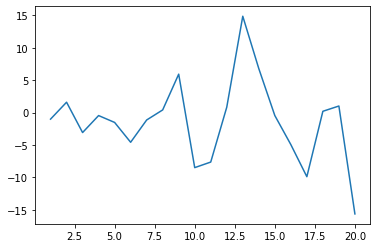

In [15]:
# define linear model

test_losses = np.zeros(20)

# train the model
for train_size in range(1, 21):
# if True:
    
#     train_size = 100
    batch_size = train_size
    # w = torch.tensor(1., requires_grad=True)
    model = nn.Linear(1, 1, bias=False)
    # define optimizer
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    x_train = torch.unsqueeze(torch.from_numpy(np.append(np.random.normal(-mu,sigma,train_size),np.random.normal(mu,sigma,train_size))), dim=1)
    y_train = torch.cat([-torch.ones(train_size), torch.ones(train_size)])
    x_test = torch.unsqueeze(torch.from_numpy(np.append(np.random.normal(-mu,sigma,test_size),np.random.normal(mu,sigma,test_size))), dim=1)
    y_test = torch.cat([-torch.ones(test_size), torch.ones(test_size)])

    # y_test = torch.unsqueeze(torch.cat([-torch.ones(test_size), torch.ones(test_size)]), dim=1)
    # x_test = torch.unsqueeze(torch.normal(mu*y_test, sigma), dim=1)

    # define datasets and data loaders
    train_set = Data.TensorDataset(x_train, y_train)
    train_loader = Data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_set = Data.TensorDataset(x_test, y_test)
    test_loader = Data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        epoch_adversarial(train_loader, model)
        
#     print('test_loss:', test_loss(test_loader, model))

    test_losses[train_size-1] = test_loss(test_loader, model)

# logging
# print('test_losses', test_losses)

plt.plot(np.arange(1, 21), test_losses)

In [16]:
x_train

tensor([[ 0.6035],
        [-4.0374],
        [-1.3429],
        [-2.3919],
        [-2.0535],
        [ 0.3774],
        [-0.7801],
        [ 2.8456],
        [-0.0246],
        [-4.9006],
        [-0.7880],
        [-2.3759],
        [-0.5359],
        [-4.0086],
        [-1.1138],
        [-1.5675],
        [-2.3710],
        [-0.5976],
        [ 1.7017],
        [-2.0140],
        [ 3.0894],
        [ 0.3154],
        [ 1.4414],
        [ 1.3209],
        [ 3.2101],
        [ 3.1454],
        [ 1.5950],
        [-0.1034],
        [-0.5298],
        [ 0.4137],
        [-1.6338],
        [ 0.5363],
        [-0.4049],
        [ 5.1609],
        [-2.2905],
        [ 3.2077],
        [ 4.0516],
        [ 0.3585],
        [ 2.9817],
        [ 6.4288]], dtype=torch.float64)

In [8]:
list(model.parameters())

[Parameter containing:
 tensor([[0.5536]], requires_grad=True)]